# Timing methods

This notebook demonstrates some of the "quick-look" timing analyses available in `opticam`.

## Preface

`stingray` is designed primarily for analysing X-ray data, and so is perhaps not ideal for OPTICAM data products. That said, `stingray` provides a number of useful routines that can (mostly) be applied to arbitrary time series, provided some care is taken.

## Generating and Reducing Data

Before we can explore the different timing analyses provided in `opticam`, we need some light curves to analyse. For this example, I'll quickly generate and reduce some gappy observations (see the [Reduction Tutorial](reduction.ipynb) for more details on data reduction):

In [1]:
import opticam

opticam.generate_gappy_observations(
    out_dir='timing_analysis_tutorial/data',
    n_images=500,  # generate lots of observations to create long light curves
    binning_scale=8,  # use large binning scale to reduce disk space
    circular_aperture=False,  # disable circular aperture shadow for simplicity
)

reducer = opticam.Reducer(
    data_directory='timing_analysis_tutorial/data',
    out_directory='timing_analysis_tutorial/reduced',
    verbose=True,
    remove_cosmic_rays=False,
    show_plots=False,
    )
reducer.create_catalogs()

phot = opticam.OptimalPhotometer()
reducer.photometry(phot)

[OPTICAM] variable source is at (65, 57)
[OPTICAM] variability RMS: 0.02 %
[OPTICAM] variability frequency: 0.135 Hz
[OPTICAM] variability phase lags:
    [OPTICAM] g-band: 0.000 radians
    [OPTICAM] r-band: 1.571 radians
    [OPTICAM] i-band: 3.142 radians


Generating observations: 100%|██████████|[00:41<00:00]

[OPTICAM] timing_analysis_tutorial/reduced not found, attempting to create ...
[OPTICAM] timing_analysis_tutorial/reduced created.



[OPTICAM] Scanning data directory: 100%|██████████|[00:01<00:00]
/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/opticam/utils/data_checks.py:207: UserWarning: [OPTICAM] Large time gap detected between 240101g200000108o.fits.gz and 240101g200000374o.fits.gz (48.995 s compared to the median time difference of 1.000 s). This may cause alignment issues. If so, consider moving all files after this gap to a separate directory.
  warnings.warn(string)
/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/opticam/utils/data_checks.py:207: UserWarning: [OPTICAM] Large time gap detected between 240101g200000449o.fits.gz and 240101g200000010o.fits.gz (19.998 s compared to the median time difference of 1.000 s). This may cause alignment issues. If so, consider moving all files after this gap to a separate directory.
  warnings.warn(string)
/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/opticam/utils/data_checks.py:207: UserWarning: [OPTICAM] Large time gap

[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 341 g-band images.
[OPTICAM] 341 r-band images.
[OPTICAM] 341 i-band images.
[OPTICAM] Creating source catalogs


[OPTICAM] Aligning g-band images: 100%|██████████|[00:04<00:00]


[OPTICAM] Done.
[OPTICAM] 341 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:03<00:00]

[OPTICAM] Done.
[OPTICAM] 341 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.



[OPTICAM] Aligning i-band images: 100%|██████████|[00:03<00:00]


[OPTICAM] Done.
[OPTICAM] 341 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.
[OPTICAM] Photometry results will be saved to lcs/optimal in timing_analysis_tutorial/reduced.


[OPTICAM] Performing photometry on g-band images: 100%|██████████|[00:03<00:00]
[OPTICAM] Performing photometry on r-band images: 100%|██████████|[00:02<00:00]
[OPTICAM] Performing photometry on i-band images: 100%|██████████|[00:03<00:00]


In [2]:
dphot = opticam.DifferentialPhotometer(
    out_directory='timing_analysis_tutorial/reduced',
    show_plots=False,
)

analyser = dphot.get_relative_light_curve(
    fltr='g-band',
    target=2,
    comparisons=1,
    phot_label='optimal',
    match_other_cameras=True,
    show_diagnostics=False,
)

[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] g-band target ID 2 was matched to r-band target ID 2
[OPTICAM] g-band comparison ID 1 was matched to r-band comparison ID 1
[OPTICAM] g-band target ID 2 was matched to i-band target ID 2
[OPTICAM] g-band comparison ID 1 was matched to i-band comparison ID 1


/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


We now have an `Analyzer` instance that provides a number of quick-look timing analyses routines. Under-the-hood, these routines use the `stingray` Python package, so if a particular `stingray` routine is not implemented in `opticam`, a light curve from the `Analyzer` instance can be passed directly to `stingray` instead (more on this later). By using `stingray`, the results returned by `opticam.Analyzer` methods are intended to be compatible with existing analysis pipelines, or provide a feature-rich framework in which to develop analysis pipelines.

Let's first take a look at our `Analyzer` light curves. Since these observations contain gaps, we can also visualise the Good Time Intervals by passing `show_gtis=True` to `plot_light_curves()`:

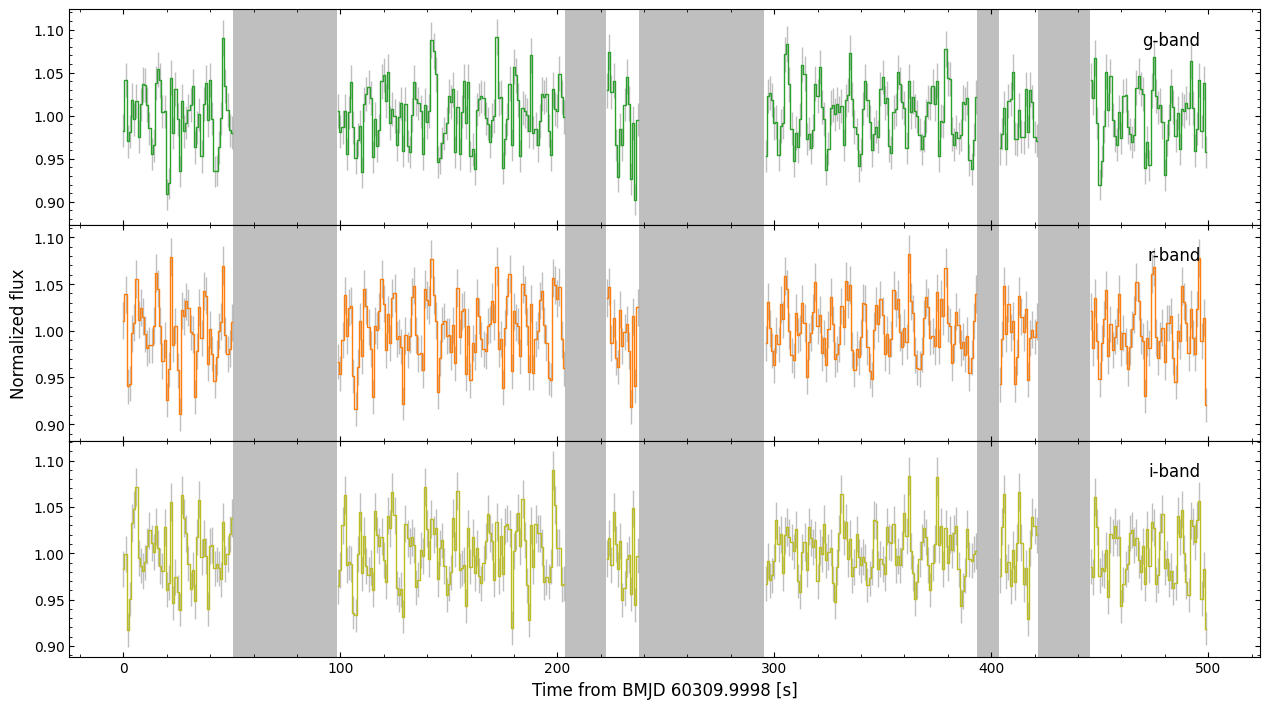

In [3]:
fig = analyser.plot_light_curves(
    show_gtis=True,
)

As we can see, we have three clearly variable, gappy light curves. Let's now perform a few quick-look timing analyses on these light curves.

## Periodograms

Often times, users might want to compute the periodograms of their light curves. `stingray` implements both the Lomb-Scargle periodogram (LSP) and the classical periodogram (FFT). Both of these are also implemented in `opticam` for convenience.

Since `opticam` computes *relative light curves*, while `stingray` assumes that light curves are in units of counts, any `Analyzer` methods that use `stingray` routines will default to `norm="frac"`. The fractional RMS normalization is valid for relative light curves, while the absolute RMS normalization (`norm="abs"`), will give the same results as the fractional RMS normalisation *provided the light curve is normalised to a mean flux of 1*. In general, try to stick with `norm="frac"` since it's scale-invariant (more on this later).

Let's first take a look at the Lomb-Scargle periodogram:

/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


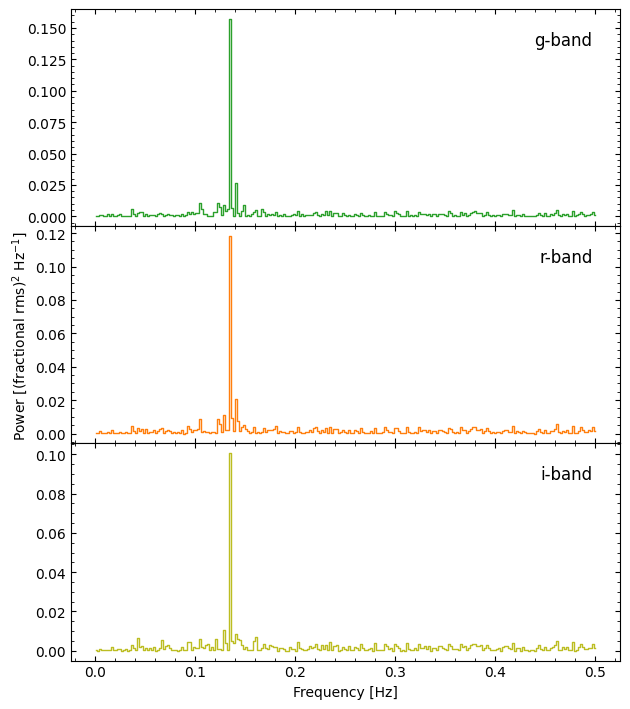

In [4]:
lsps = analyser.compute_lomb_scargle_periodograms()

We have three Lomb-Scarlge periodograms, all of which show a strong peak at a frequency of about 0.14 Hz.

Like many of the timing analysis methods of `Analyzer`, `compute_lomb_scargle_periodograms()` returns a dictionary of results. In this case, the keys list the filters and the values list the corresponding `stingray.lombscargle.LombScarglePowerspectrum` instances: 

In [5]:
lsps

{'g-band': <stingray.lombscargle.LombScarglePowerspectrum at 0x7db494ca3620>,
 'r-band': <stingray.lombscargle.LombScarglePowerspectrum at 0x7db48b5ad310>,
 'i-band': <stingray.lombscargle.LombScarglePowerspectrum at 0x7db48b5ad950>}

Let's find the peak frequency for each periodogram:

In [6]:
import numpy as np

for fltr, lsp in lsps.items():
    print('Peak frequency:', lsp.freq[np.argmax(lsp.power)], 'Hz')

Peak frequency: 0.13528395820116063 Hz
Peak frequency: 0.13528395820116063 Hz
Peak frequency: 0.13528395820116063 Hz


As we can see, all three bands show a periodicity at $\sim$ 0.135 Hz (which is the true frequency of variability for our source of interest). We also see a bit of aliasing due to the gaps in our observations.

Let's compare the LSP to the classical periodogram:

In [7]:
periodograms = analyser.compute_power_spectra()

[OPTICAM] Unable to compute periodogram for g-band light curve due to gaps. Consider using either the compute_lomb_scargle_periodograms() or compute_averaged_power_spectra() methods instead.
[OPTICAM] Unable to compute periodogram for r-band light curve due to gaps. Consider using either the compute_lomb_scargle_periodograms() or compute_averaged_power_spectra() methods instead.
[OPTICAM] Unable to compute periodogram for i-band light curve due to gaps. Consider using either the compute_lomb_scargle_periodograms() or compute_averaged_power_spectra() methods instead.


As we can see, computing the classical periodogram fails because the data contain gaps. Let's try computing the averaged periodogram instead. When computing an averaged periodogram, a segment size must be specified; to avoid issues with units, `opticam` requires this segment size by an `astropy.units.quantity.Quantity` instance:

[OPTICAM] 8 g-band segments averaged.
[OPTICAM] 8 r-band segments averaged.
[OPTICAM] 8 i-band segments averaged.


/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


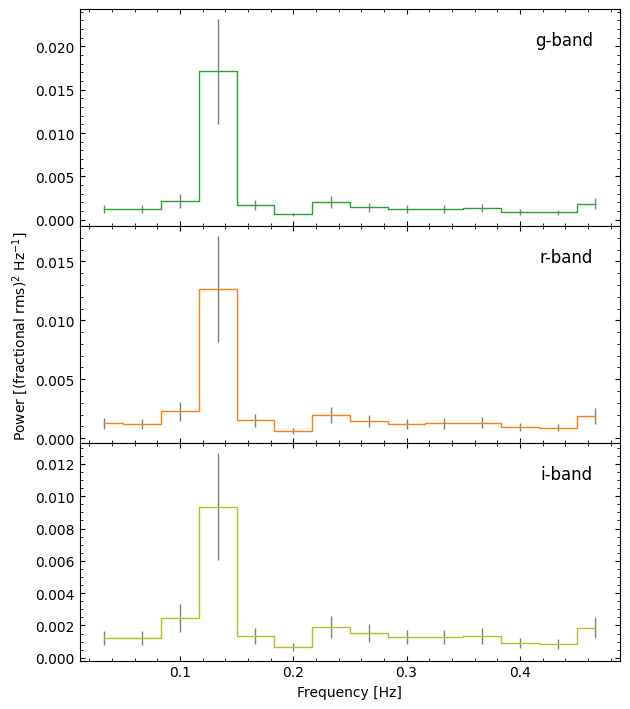

In [8]:
import astropy.units as u

segment_size = 30 * u.s

averaged_periodograms = analyser.compute_averaged_power_spectra(
    segment_size=segment_size,
)

Computing averaged periodograms works, since the gaps can be filtered out, but we don't really have enough data in this case to get meaningful results (note each averaged periodogram is comprised of just eight segments). When averaging Fourier products, the general consensus is to average at least 30 segments to get trustworthy results. However, generating enough data to get 30 complete segments would take up a lot of disk space, so I'll leave this as an exercise for the user.

## Phase Folding

It is common to phase fold light curves on candidate frequencies or periods to visualise the pulse profile. This is implemented in `opticam` for convenience via the `phase_fold_light_curves()` method of `Analyzer`. First, however, we must define our candidate period. To avoid issues with units, candidate periods must be an `astropy.units.quantity.Quantity` instance:

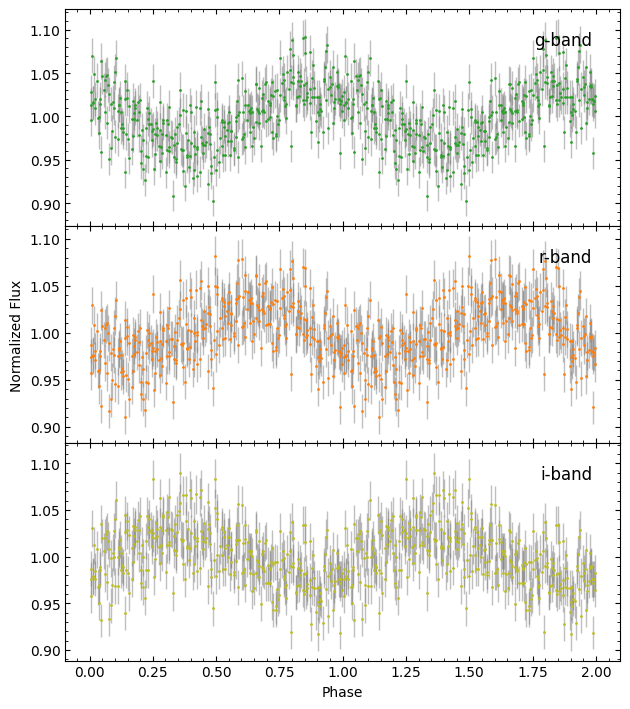

In [9]:
f_signal = 0.135 * u.Hz  # periodogram peak frequency
p_signal = 1 / f_signal

phase_folds = analyser.phase_fold_light_curves(
    period=p_signal,
)

We can also phase bin to make the pulse profile clearer:

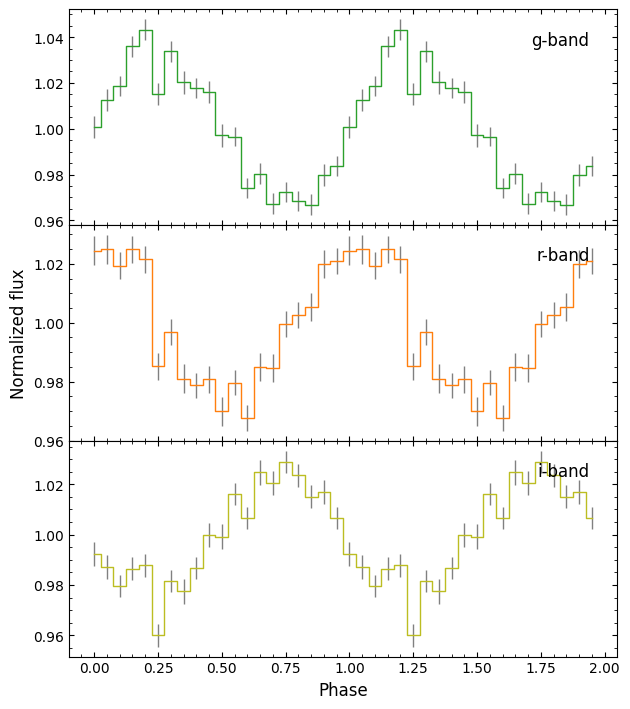

In [10]:
phase_bins = analyser.phase_bin_light_curves(
    period=p_signal,
    n_bins=20,
)

Now we can see the pulse profiles more clearly, though it's still pretty noisy in this case since our light curve isn't very long.

It's also clear from the above plots that there is a lag in the pulsations between the different bands. Let's quantify this.

## Lags

One of the great things about OPTICAM is that it provides simultaneous three-colour observations. As such, it is possible to search for wavelength-dependent lags; `opticam`'s `Analyzer` class makes this easy via the `compute_cross_correlations()` method:

/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


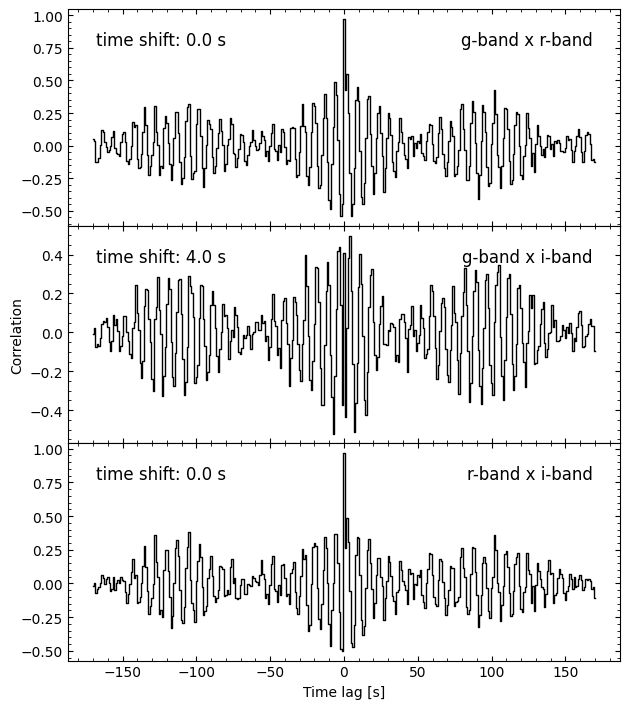

In [11]:
corrs = analyser.compute_cross_correlations()

The `compute_cross_correlations()` method computes the cross-correlations between each pair of light curves in the `Analyzer` instance. As we can see from the above plot, the $r$-band lags the $g$-band by 2 s (since the time shift is negative, the second filter lags the first filter), and the $i$-band lags the $r$-band by 2 s as well. The true lag between these bands is a quarter period; since the period is $1 / 0.135 = 7.4$ s, this is 1.85 s. Within the time resolution of our light curves (1 s), we can therefore correctly recover the lag.

## Using `stingray` Directly

### A Cautionary Tale

Since `Analyzer` stores light curves as `stingray.Lightcurve` instances, we can pass them directly to a number of `stingray` timing analysis routines. However, `stingray` assumes light curves are in units of counts with Poisson errors, while our light curves are relative (unitless) with Gaussian errors. As such, care must be taken in regards to units (e.g., in normalisations), and some routines either won't work as expected or won't work at all. As an instructive example, let's say we want to compute the cross spectrum between our $g$- and $r$-band light curves:

8it [00:00, 8993.42it/s]
/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/fourier.py:1134: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/fourier.py:1161: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt((1 - gsq) / (2 * gsq * n_ave))


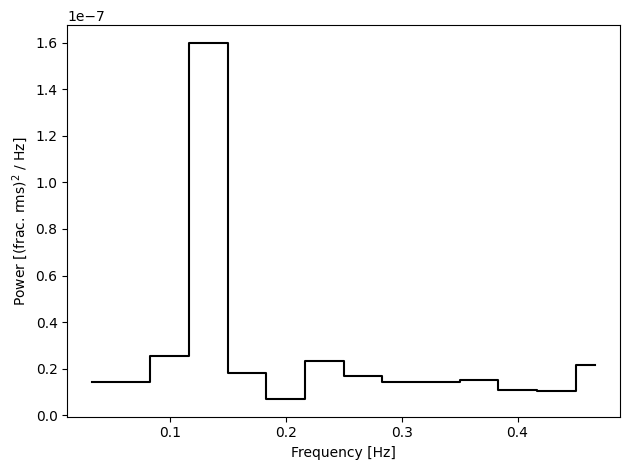

In [12]:
from stingray import AveragedCrossspectrum
from matplotlib import pyplot as plt

avg_cs = AveragedCrossspectrum.from_lightcurve(
    lc1=analyser.light_curves['g-band'],
    lc2=analyser.light_curves['r-band'],
    norm='frac',
    segment_size=(segment_size).to_value(u.d),  # stingray assumes all time values are in seconds but OPTICAM uses Barycentric MJD
)

avg_cs_amplitude = np.abs(avg_cs.power)

fig, ax = plt.subplots(tight_layout=True)

ax.step(
    avg_cs.freq / 86400,  # convert freq from cyc/d to Hz
    avg_cs_amplitude,
    where='mid',
    c='k',
)

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power [(frac. rms)$^2$ / Hz]')

plt.show()

That looks how we'd expect. So far so good. Let's try to compute the coherence between these two light curves and check it's in the expected range ($0 \leq \text{coherence} \leq 1$):

In [13]:
coh, coh_err = avg_cs.coherence()

print(np.logical_and(coh >= 0, coh <= 1).all())

False


/home/zac/miniforge3/envs/opticam/lib/python3.13/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Number of segments used in averaging is significantly low. The result might not follow the expected statistical distributions.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Uh oh, we have unphysical coherence values! Let's take a look at some of them:

In [14]:
for i in range(5):
    print(f'Coherence: {coh[i]}, error: {coh_err[i]}')

Coherence: 84713.40113072538, error: -12328012.195343288
Coherence: 84797.92955302347, error: -12346468.582114352
Coherence: 26704.704686473273, error: -2181902.8558269525
Coherence: 604.6490646352105, error: -7421.748426076806
Coherence: 52662.77314015466, error: -6042509.536817959


Our coherence estimates are in the thousands, and our error estimates are negative. Something is very wrong...

The issue is due to `stingray` assuming Poisson statistics. Since we know the phase lag between these two light curves, let's see what happens if we try to compute it from the averaged cross spectrum:

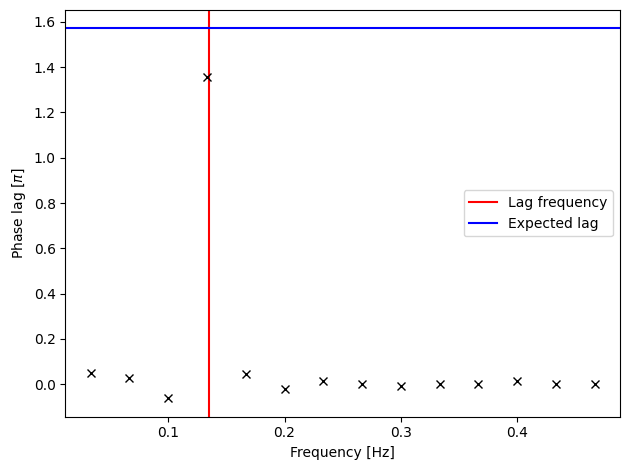

In [15]:
plags, plags_err = avg_cs.phase_lag()

fig, ax = plt.subplots(tight_layout=True)

ax.errorbar(
    avg_cs.freq / 86400,
    plags,
    plags_err,
    fmt='kx',
)

ax.axvline(
    0.135,
    c='red',
    label='Lag frequency'
    )
ax.axhline(
    np.pi / 2,
    c='blue',
    label='Expected lag'
    )
ax.legend()

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Phase lag [$\\pi$]')

plt.show()

We get the correct phase lag at the correct frequency. However, we don't seem to have any error bars, and so it's impossible to quantify the significance of this lag. Let's see what our error bars are:

In [16]:
print(plags_err)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


Our errors are all `NaN`s! This is another consequence of our light curves not having Poisson errors.

### A Hacky Fix

To work around `stingray`'s requirement for Poisson errors, we can trick it into thinking our relative light curves are actually in units of counts by scaling them by a suitably large value (e.g., 10,000). We'll also want to convert the time values from Barycentric MJD to seconds:

In [17]:
from stingray import Lightcurve

scale_factor = 1e4

lc = analyser.light_curves['g-band']
t_ref = np.min(lc.time)
t = 86400 * (lc.time - t_ref)  # convert time from MJD to s
gti = 86400 * (lc.gti - t_ref)  # convert GTIs from MJD to s
f = lc.counts * scale_factor  # scale fluxes so stingray thinks they're counts
g_lc = Lightcurve(t, f, gti=gti)  # do not pass errors or define err_dist

lc = analyser.light_curves['r-band']
t = 86400 * (lc.time - t_ref)  # convert time from MJD to s
gti = 86400 * (lc.gti - t_ref)  # convert GTIs from MJD to s
f = lc.counts * scale_factor  # scale fluxes so stingray thinks they're counts
r_lc = Lightcurve(t, f, gti=gti)  # do not pass errors or define err_dist

avg_cs = AveragedCrossspectrum.from_lightcurve(
    g_lc,
    r_lc,
    segment_size=segment_size.value,  # segment size in seconds
    norm='frac',
    )

8it [00:00, 11471.60it/s]


The fractional RMS normalisation (`norm='frac'`) is scale-invariant, so it should give us the same averaged periodogram as before (provided we use the same segment length). Let's verify this:

In [18]:
from stingray import AveragedPowerspectrum

avg_ps = AveragedPowerspectrum.from_lightcurve(
    g_lc,
    segment_size=segment_size.value,
    norm='frac',
    )

print(np.allclose(avg_ps.power, averaged_periodograms['g-band'].power))

8it [00:00, 14302.83it/s]

True


As we can see, our scaled $g$-band light curve gives the same averaged power spectrum as our initial relative light curve. Let's now try to compute the averaged cross spectrum, coherence, and phase lags using our scaled light curves:

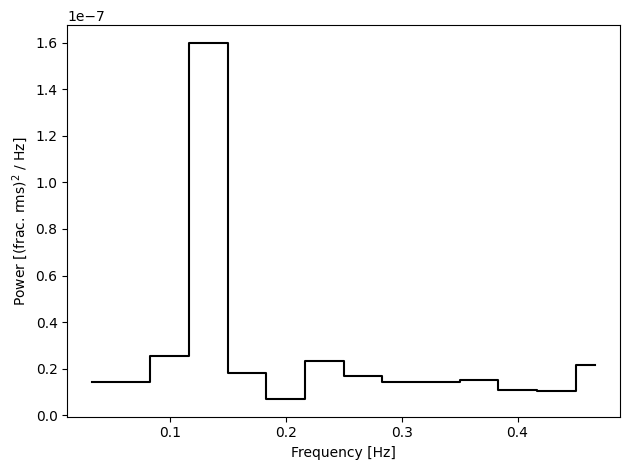

In [19]:
fig, ax = plt.subplots(tight_layout=True)

ax.step(
    avg_cs.freq,
    avg_cs_amplitude,
    where='mid',
    c='k',
)

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power [(frac. rms)$^2$ / Hz]')

plt.show()

As with the averaged power spectrum, the averaged cross spectrum looks the same as before (since we're using `norm="frac"`). Again, so far so good. Let's see if we can compute the coherence this time:

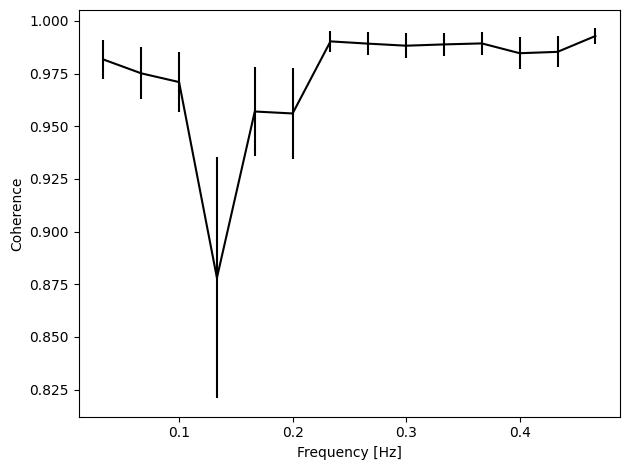

In [20]:
fig, ax = plt.subplots(tight_layout=True)

coh, coh_err = avg_cs.coherence()

ax.errorbar(
    avg_cs.freq,
    coh,
    coh_err,
    c='black',
)

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Coherence')

plt.show()

We have a coherence plot!

Let's see how the phase lags look now:

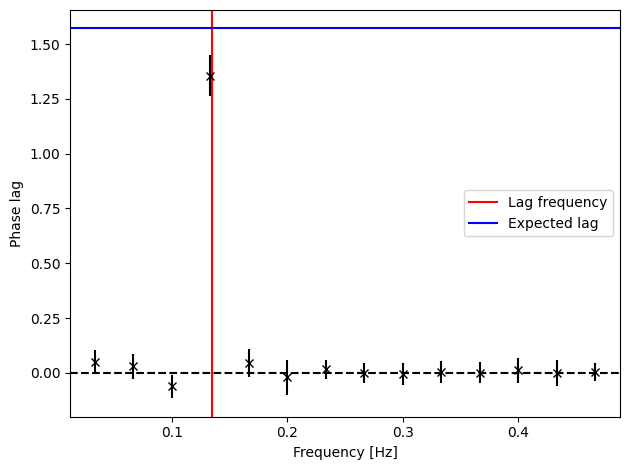

In [21]:
plags, plags_err = avg_cs.phase_lag()

fig, ax = plt.subplots(tight_layout=True)

ax.errorbar(
    avg_cs.freq,
    plags,
    plags_err,
    fmt='kx',
)

ax.axvline(
    0.135,
    c='red',
    label='Lag frequency'
    )
ax.axhline(
    np.pi / 2,
    c='blue',
    label='Expected lag'
    )
ax.axhline(
    0,
    c='black',
    ls='--'
    )
ax.legend()

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Phase lag')

plt.show()

We have errors on our phase lags, and now we can tell that the lag is not only consistent the correct value (to within a few sigma), but is also inconsistent with zero! Let's quantify its significance:

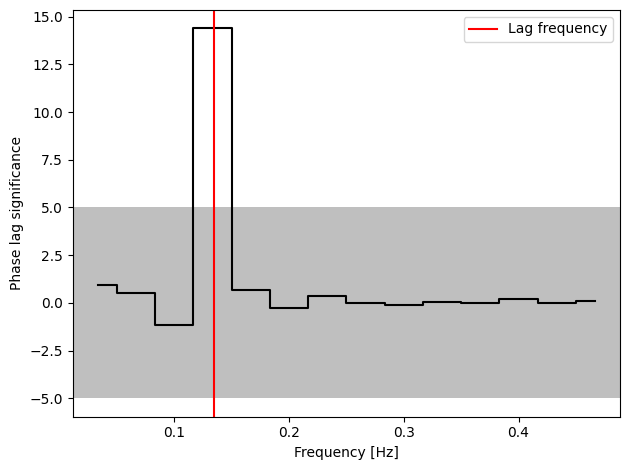

In [22]:
fig, ax = plt.subplots(tight_layout=True)

ax.step(
    avg_cs.freq,
    plags / plags_err,
    where='mid',
    c='black',
)

ax.fill_between(
    ax.set_xlim(),
    -5, 5,
    color='grey',
    alpha=.5,
    edgecolor='none',
)

ax.axvline(
    0.135,
    c='red',
    label='Lag frequency'
    )

ax.legend()

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Phase lag significance')

plt.show()

Now we can see that the phase lag is significant to $\gg 5 \sigma$, as we would hope!

That concludes the timing methods tutorial for `opticam`! The timing methods of `Analyzer` demonstrated here are intended as "quick-look" analyses, while more complete analyses are made easy thanks to `stingray`. Note that special care (and hacky workarounds) may be needed to get the most out of `stingray`.